In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from ops import create_mask, metrics_AP, complete_nan_values
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from model.callbacks import UpdateWeights
from model.models import UNET
from model.losses import WBCE
import matplotlib.pyplot as plt
import time
import tensorflow as tf
import os
import gc
import json
import importlib
import numpy as np

## Parameters

In [3]:
with open(f'00_params.json') as param_file:
    params = json.load(param_file)

img_path = 'imgs' 
n_opt_layer = 26 #number of OPT layers, used to split de input data between OPT and SAR

number_class = 3
weights = params['weights']
times= params['times']
exp = params['exp']

overlap = params['overlap']
patch_size = params['patch_size']
batch_size = params['batch_size']

img_type = params['img_type']
cond = params['cond']
test_cond = params['test_cond']

nb_filters = params['nb_filters']

method = params['method']
module = importlib.import_module('model.models')
exp_model = getattr(module, method)

grid_size = params['grid_size']

tiles_tr = params['tiles_tr']
tiles_val = params['tiles_val']

In [4]:
print(f'Experiment: {exp}')
print(f'Test Cond: {test_cond}')
print(f'Model: {method}')

Experiment: 3
Test Cond: no_cloudy
Model: ResUNET


## Load file

In [5]:
final_mask1 = np.lib.format.open_memmap(os.path.join(img_path, 'final_mask1.npy'))
print('Labels stack:', final_mask1.shape)


Labels stack: (17730, 9203)


## Create tiles mask

mask:  (17730, 9203)
ref : (17730, 9203)


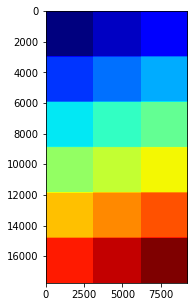

In [6]:
mask_tiles = create_mask(final_mask1.shape[0], final_mask1.shape[1], grid_size=grid_size)

print('mask: ',mask_tiles.shape)
print('ref :', final_mask1.shape)
plt.figure(figsize=(10,5))
plt.imshow(mask_tiles, cmap='jet')

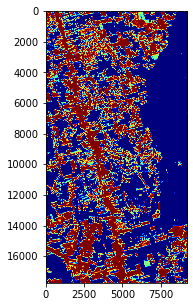

In [7]:
plt.figure(figsize=(10,5))
plt.imshow(final_mask1, cmap = 'jet')

## Define tiles for training, validation and tests.

In [8]:
tiles_ts = (list(set(np.arange(20)+1)-set(tiles_tr)-set(tiles_val)))

mask_amazon_ts = np.zeros_like(mask_tiles, dtype = np.uint8)
for ts_ in tiles_ts:
    mask_amazon_ts[mask_tiles == ts_] = 1

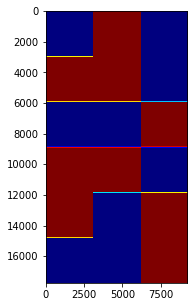

In [9]:
plt.figure(figsize=(10,5))
plt.imshow(mask_amazon_ts, cmap='jet')

## Creating folders, if necessary

In [10]:
path_exp = os.path.join(img_path, 'experiments', f'exp_{exp}')
path_models = os.path.join(path_exp, 'models')
path_maps = os.path.join(path_exp, 'pred_maps')

if not os.path.exists(path_exp):
    os.makedirs(path_exp)   
if not os.path.exists(path_models):
    os.makedirs(path_models)   
if not os.path.exists(path_maps):
    os.makedirs(path_maps)

## Oppening files

In [11]:
mean_prob = np.lib.format.open_memmap(os.path.join(path_maps, 'prob_mean.npy'))

## Plotting mean prediction and reference

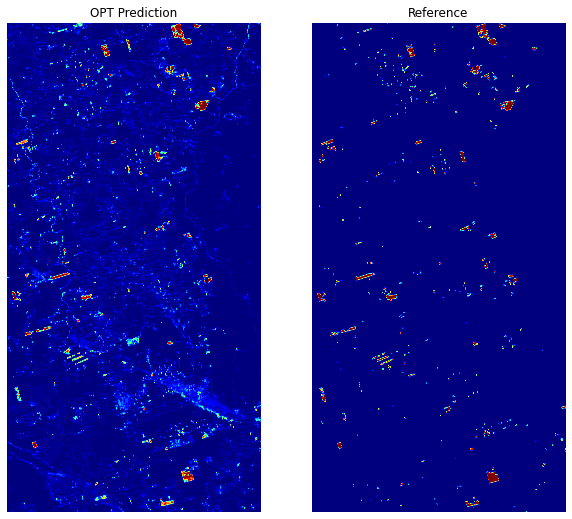

In [12]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(121)
plt.title(f'{img_type} Prediction')
ax1.imshow(mean_prob, cmap ='jet')
ax1.axis('off')

ax2 = fig.add_subplot(122)
plt.title('Reference')
ax2.imshow(tf.keras.utils.to_categorical(final_mask1, 3)[:,:,1], cmap ='jet')
ax2.axis('off')
plt.savefig(os.path.join(path_exp, 'pred.png'))

## Computing metrics

In [13]:
t0 = time.time()
mean_prob = mean_prob[:final_mask1.shape[0], :final_mask1.shape[1]]


ref1 = np.ones_like(final_mask1).astype(np.uint8)

ref1 [final_mask1 == 2] = 0
TileMask = mask_amazon_ts * ref1
GTTruePositives = final_mask1==1
    
Npoints = 50

Pmax = np.max(mean_prob[GTTruePositives * TileMask ==1])
ProbList = np.linspace(Pmax,0,Npoints)

del ref1, TileMask, GTTruePositives
gc.collect()

metrics = metrics_AP(ProbList, mean_prob, final_mask1, mask_amazon_ts, 625, 6)
   
np.save(os.path.join(path_exp, 'acc_metrics.npy'),metrics)

print(f'elapsed time: {(time.time()-t0)/60} mins')

elapsed time: 25.872597455978394 mins


## Complete NaN values

In [14]:
metrics_copy = np.array(metrics)
metrics_copy = complete_nan_values(metrics_copy)

## Compute the Average Precision score

OPT AP 0.8239449419224449


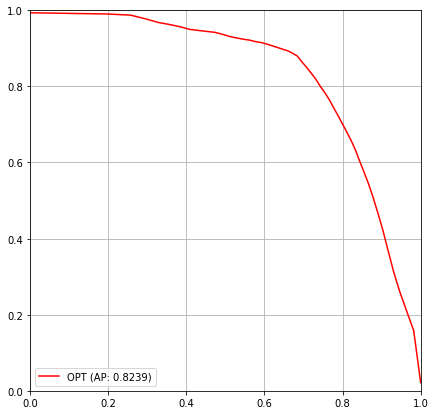

In [15]:
# Comput Mean Average Precision (mAP) score 
Recall = metrics_copy[:,0]
Precision = metrics_copy[:,1]
AA = metrics_copy[:,2]
   
Recall_ = np.insert(Recall, 0, 0)
Precision_ = np.insert(Precision, 0, Precision[0])
DeltaR = Recall_[1:]-Recall_[:-1]
AP = np.sum(Precision_[1:]*DeltaR)
print(f'{img_type} AP', AP)


# Plot Recall vs. Precision curve
plt.figure(figsize=(7,7))
plt.plot(metrics_copy[:,0],metrics_copy[:,1], 'r-', label = f'{img_type} (AP: {AP:.4f})')
plt.legend(loc="lower left")
ax = plt.gca()
ax.set_ylim([0,1])
ax.set_xlim([0,1])
plt.grid()
plt.savefig(os.path.join(path_exp, 'result.png'))